## **DATA MODELING**

#### **Đề tài**: *Hệ thống dự đoán giá trị chuyển nhượng cầu thủ bóng đá*

#### **Vấn đề quan tâm**: *Phân tích các yếu tố ảnh hưởng đến giá trị chuyển nhượng cầu thủ bóng đá và xây dựng mô hình dự đoán giá trị thị trường dựa trên đặc điểm và thành tích thi đấu.*

### **I. Import các thư viện**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from tqdm.auto import tqdm
import joblib
import os

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Using LightGBM")
print(f"Started at: {time.strftime('%H:%M:%S')}\n")

Libraries imported successfully!
Using LightGBM
Started at: 16:21:14



### **II. Đọc và khám phá dữ liệu**

In [5]:
INPUT_FOLDER = "."  
OUTPUT_FOLDER = "output"
FILENAME = "football_players_dataset.csv"

INPUT_FILE = os.path.join(INPUT_FOLDER, FILENAME)
ARTIFACT_FOLDER = os.path.join(OUTPUT_FOLDER, "artifacts")
FIGURES_FOLDER = os.path.join(OUTPUT_FOLDER, "figures")
MODEL_FOLDER = os.path.join(OUTPUT_FOLDER, "models")
REPORT_FOLDER = os.path.join(OUTPUT_FOLDER, "reports")

os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(ARTIFACT_FOLDER, exist_ok=True)
os.makedirs(FIGURES_FOLDER, exist_ok=True)
os.makedirs(MODEL_FOLDER, exist_ok=True)
os.makedirs(REPORT_FOLDER, exist_ok=True)

In [6]:
print("="*80)
print("LOADING DATA")
print("="*80)

df = pd.read_csv(INPUT_FILE)

print(f"\nLoaded {len(df):,} samples with {df.shape[1]} features")
print(f"\nShape: {df.shape}")
print(f"   - Samples: {df.shape[0]:,}")
print(f"   - Features: {df.shape[1]}")

print("\nColumn Types:")
print(df.dtypes.value_counts())

print("\nFirst 5 rows:")
print(df.head())

missing = df.isnull().sum()
if missing.sum() > 0:
    print(f"\nMissing values found: {missing[missing > 0].sum()} total")
    print("\nColumns with missing values:")
    print(missing[missing > 0])
else:
    print("\nNo missing values!")

LOADING DATA

Loaded 14,977 samples with 43 features

Shape: (14977, 43)
   - Samples: 14,977
   - Features: 43

Column Types:
float64    40
object      3
Name: count, dtype: int64

First 5 rows:
    age  nationality current_club        league  appearances  minutes_played  \
0  27.0      Uruguay  Auckland FC  A-League Men         26.0          2268.0   
1  31.0  New Zealand  Auckland FC  A-League Men         26.0          2198.0   
2  26.0  New Zealand  Auckland FC  A-League Men         25.0          2142.0   
3  35.0        Japan  Auckland FC  A-League Men         23.0          2024.0   
4  27.0  New Zealand  Auckland FC  A-League Men         26.0          1782.0   

   is_DF  is_MF  is_FW  goals  ...  passes_received_per90  \
0    0.0    0.0    1.0    9.0  ...                  28.28   
1    1.0    0.0    0.0    2.0  ...                  31.25   
2    1.0    0.0    0.0    4.0  ...                  31.25   
3    1.0    0.0    0.0    3.0  ...                  38.17   
4    0.0    1.0   

### **III. Feature Engineering**

In [7]:
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

fe_start = time.time()

df_features = df.copy()
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print("\nLog transformation...")
skewed_features = []
for col in numeric_cols:
    if col not in ['market_value', 'is_GK', 'is_DF', 'is_MF', 'is_FW']:
        if abs(df_features[col].skew()) > 1.0:
            df_features[f'{col}_log'] = np.log1p(df_features[col])
            skewed_features.append(col)
print(f"Transformed {len(skewed_features)} features")

print("Creating ratio features...")
if 'goals' in df_features.columns and 'shots_per90' in df_features.columns:
    df_features['goals_per_shot'] = df_features['goals'] / df_features['shots_per90'].replace(0, 0.01)

if 'passes_completed_per90' in df_features.columns and 'pass_completion_pct' in df_features.columns:
    df_features['pass_efficiency'] = df_features['passes_completed_per90'] * df_features['pass_completion_pct'] / 100

if all(col in df_features.columns for col in ['interceptions_per90', 'blocks_per90']):
    df_features['defensive_contribution'] = df_features['interceptions_per90'] + df_features['blocks_per90']

if all(col in df_features.columns for col in ['progressive_passes_per90', 'progressive_carries_per90']):
    df_features['total_progressive'] = df_features['progressive_passes_per90'] + df_features['progressive_carries_per90']

print("Created ratio features")

print("Creating interaction features...")
df_features['age_experience'] = df_features['age'] * np.log1p(df_features['minutes_played'])

if 'minutes_played' in df_features.columns and 'appearances' in df_features.columns:
    df_features['minutes_per_game'] = df_features['minutes_played'] / df_features['appearances'].replace(0, 1)

print("Created interaction features")

print("Creating polynomial features...")
for feat in ['goals', 'assists', 'minutes_played']:
    if feat in df_features.columns:
        df_features[f'{feat}_squared'] = df_features[feat] ** 2

print("Created polynomial features")

print("Encoding categorical variables...")
categorical_cols = ['nationality', 'position', 'current_club', 'league']

for col in ['nationality', 'current_club']:
    if col in df_features.columns:
        target_mean = df_features.groupby(col)['market_value'].mean()
        df_features[f'{col}_target_enc'] = df_features[col].map(target_mean)
        df_features[f'{col}_target_enc'].fillna(df_features['market_value'].mean(), inplace=True)

le = LabelEncoder()
for col in ['position', 'league']:
    if col in df_features.columns:
        df_features[f'{col}_label_enc'] = le.fit_transform(df_features[col].astype(str))

for col in categorical_cols:
    if col in df_features.columns:
        freq = df_features[col].value_counts()
        df_features[f'{col}_freq'] = df_features[col].map(freq)

print("Encoded categorical variables")

fe_time = time.time() - fe_start
print(f"\nFeature engineering completed in {fe_time:.2f}s")
print(f"Total features: {len(df_features.columns)}")


FEATURE ENGINEERING

Log transformation...
Transformed 24 features
Creating ratio features...
Created ratio features
Creating interaction features...
Created interaction features
Creating polynomial features...
Created polynomial features
Encoding categorical variables...
Encoded categorical variables

Feature engineering completed in 0.04s
Total features: 82


### **IV. Feature Selection**

In [8]:
print("\n" + "="*80)
print("FEATURE SELECTION")
print("="*80)

exclude_cols = ['market_value', 'position_category', 'nationality', 'position', 
                'current_club', 'league']

feature_cols = [col for col in df_features.columns 
                if col not in exclude_cols 
                and df_features[col].dtype in ['int64', 'float64']]

X_temp = df_features[feature_cols].fillna(0)
y_temp = df_features['market_value']

print(f"Calculating correlations for {len(feature_cols)} features...")
correlations = {}
for col in tqdm(feature_cols, desc="Correlations", leave=False):
    try:
        correlations[col] = abs(X_temp[col].corr(y_temp))
    except:
        correlations[col] = 0

corr_threshold = 0.05
selected_features = [feat for feat, corr in correlations.items() if corr > corr_threshold]

print(f"Selected {len(selected_features)} features (correlation > {corr_threshold})")

sorted_corr = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 features:")
for i, (feat, corr) in enumerate(sorted_corr[:10], 1):
    print(f"   {i:2d}. {feat:40s}: {corr:.4f}")


FEATURE SELECTION
Calculating correlations for 78 features...


Selected 65 features (correlation > 0.05)

Top 10 features:
    1. current_club_target_enc                 : 0.6201
    2. calculated_sum                          : 0.2726
    3. calculated_sum_log                      : 0.2716
    4. goals                                   : 0.2579
    5. goals_squared                           : 0.2493
    6. nationality_target_enc                  : 0.2470
    7. assists                                 : 0.2420
    8. goals_log                               : 0.2201
    9. touches_att_pen_per90                   : 0.2198
   10. assists_log                             : 0.2161


### **V. Data Preparation - Three-way Split**

In [9]:
print("\n" + "="*80)
print("DATA PREPARATION")
print("="*80)

Q1 = df_features['market_value'].quantile(0.01)
Q3 = df_features['market_value'].quantile(0.99)
df_clean = df_features[(df_features['market_value'] >= Q1) & 
                        (df_features['market_value'] <= Q3)].copy()

print(f"Removed outliers: {len(df_clean):,}/{len(df_features):,} samples kept ({len(df_clean)/len(df_features)*100:.1f}%)")

X = df_clean[selected_features].fillna(0)
y = df_clean['market_value']
y_log = np.log1p(y)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42, shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, shuffle=True
)

print(f"\nData split (64%/16%/20%):")
print(f"   Training:   {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Validation: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Test:       {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed with StandardScaler")


DATA PREPARATION
Removed outliers: 14,823/14,977 samples kept (99.0%)

Data split (64%/16%/20%):
   Training:   9,486 samples (64.0%)
   Validation: 2,372 samples (16.0%)
   Test:       2,965 samples (20.0%)
Feature scaling completed with StandardScaler


### **VI. Initial Model Training**

In [10]:
print("\n" + "="*80)
print("INITIAL MODEL TRAINING")
print("="*80)

model = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

train_start = time.time()
print("Training initial model...")
model.fit(X_train_scaled, y_train)
train_time = time.time() - train_start
print(f"Training completed in {train_time:.2f}s")

y_val_pred_log = model.predict(X_val_scaled)
y_test_pred_log = model.predict(X_test_scaled)

y_val_pred = np.expm1(y_val_pred_log)
y_val_orig = np.expm1(y_val)
y_test_pred = np.expm1(y_test_pred_log)
y_test_orig = np.expm1(y_test)

val_r2 = r2_score(y_val, y_val_pred_log)
test_r2 = r2_score(y_test, y_test_pred_log)
test_mse = mean_squared_error(y_test_orig, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_orig, y_test_pred)

print(f"\nInitial Performance:")
print(f"   Validation R2: {val_r2:.4f}")
print(f"   Test R2:       {test_r2:.4f}")
print(f"   Test RMSE:     EUR{test_rmse:.2f}M")
print(f"   Test MAE:      EUR{test_mae:.2f}M")

n_folds = 5
cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                           cv=n_folds, scoring='r2', n_jobs=-1)

print(f"\n{n_folds}-Fold Cross-Validation:")
print(f"   Mean R2: {cv_scores.mean():.4f} +/- {cv_scores.std():.4f}")

initial_results = {
    'val_r2': val_r2,
    'test_r2': test_r2,
    'test_rmse': test_rmse,
    'test_mae': test_mae,
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std()
}


INITIAL MODEL TRAINING
Training initial model...
Training completed in 0.97s

Initial Performance:
   Validation R2: 0.7798
   Test R2:       0.7928
   Test RMSE:     EUR3.12M
   Test MAE:      EUR1.24M

5-Fold Cross-Validation:
   Mean R2: 0.7816 +/- 0.0113


### **VII. Hyperparameter Tuning**

In [11]:
print("\n" + "="*80)
print("HYPERPARAMETER TUNING")
print("="*80)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [10, 20, 30]
}

n_combinations = 1
for v in param_grid.values():
    n_combinations *= len(v)

total_fits = n_combinations * n_folds

print(f"Parameter grid:")
for param, values in param_grid.items():
    print(f"   {param:20s}: {values}")
print(f"\nTotal combinations: {n_combinations}")
print(f"Total fits ({n_folds}-fold): {total_fits}")

base_model = lgb.LGBMRegressor(
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=n_folds,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

tune_start = time.time()
print(f"\nStarting GridSearchCV...")
grid_search.fit(X_train_scaled, y_train)
tune_time = time.time() - tune_start

print(f"\nTuning completed in {tune_time:.2f}s ({tune_time/60:.2f} min)")
print(f"\nBest parameters:")
for param, value in grid_search.best_params_.items():
    print(f"   {param:20s}: {value}")
print(f"\nBest CV R2 score: {grid_search.best_score_:.4f}")


HYPERPARAMETER TUNING
Parameter grid:
   n_estimators        : [100, 200, 300]
   learning_rate       : [0.01, 0.05, 0.1]
   max_depth           : [3, 6, 9]
   num_leaves          : [15, 31, 63]
   min_child_samples   : [10, 20, 30]

Total combinations: 243
Total fits (5-fold): 1215

Starting GridSearchCV...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Tuning completed in 387.40s (6.46 min)

Best parameters:
   learning_rate       : 0.05
   max_depth           : 6
   min_child_samples   : 20
   n_estimators        : 300
   num_leaves          : 31

Best CV R2 score: 0.7820


### **VIII. Final Model Evaluation**

In [12]:
print("\n" + "="*80)
print("FINAL MODEL EVALUATION")
print("="*80)

final_model = grid_search.best_estimator_

y_test_pred_tuned = final_model.predict(X_test_scaled)
y_test_pred_final = np.expm1(y_test_pred_tuned)
y_test_actual = np.expm1(y_test)

test_r2_tuned = r2_score(y_test, y_test_pred_tuned)
test_mse_tuned = mean_squared_error(y_test_actual, y_test_pred_final)
test_rmse_tuned = np.sqrt(test_mse_tuned)
test_mae_tuned = mean_absolute_error(y_test_actual, y_test_pred_final)
test_mape_tuned = np.mean(np.abs((y_test_actual - y_test_pred_final) / y_test_actual)) * 100

final_metrics = {
    'r2': test_r2_tuned,
    'mse': test_mse_tuned,
    'rmse': test_rmse_tuned,
    'mae': test_mae_tuned,
    'mape': test_mape_tuned
}

print(f"\nFinal Test Set Performance:")
print(f"   R2 Score:  {test_r2_tuned:.4f}")
print(f"   MSE:       EUR{test_mse_tuned:.2f}M^2")
print(f"   RMSE:      EUR{test_rmse_tuned:.2f}M")
print(f"   MAE:       EUR{test_mae_tuned:.2f}M")
print(f"   MAPE:      {test_mape_tuned:.2f}%")

improvement = (test_r2_tuned - initial_results['test_r2']) / initial_results['test_r2'] * 100
print(f"\nImprovement over baseline: {improvement:+.2f}%")


FINAL MODEL EVALUATION

Final Test Set Performance:
   R2 Score:  0.7937
   MSE:       EUR9.74M^2
   RMSE:      EUR3.12M
   MAE:       EUR1.24M
   MAPE:      92.87%

Improvement over baseline: +0.12%


### **IX. Creating Visualizations**


CREATING VISUALIZATIONS

Saved: output/figures/LGBM_final_evaluation.png


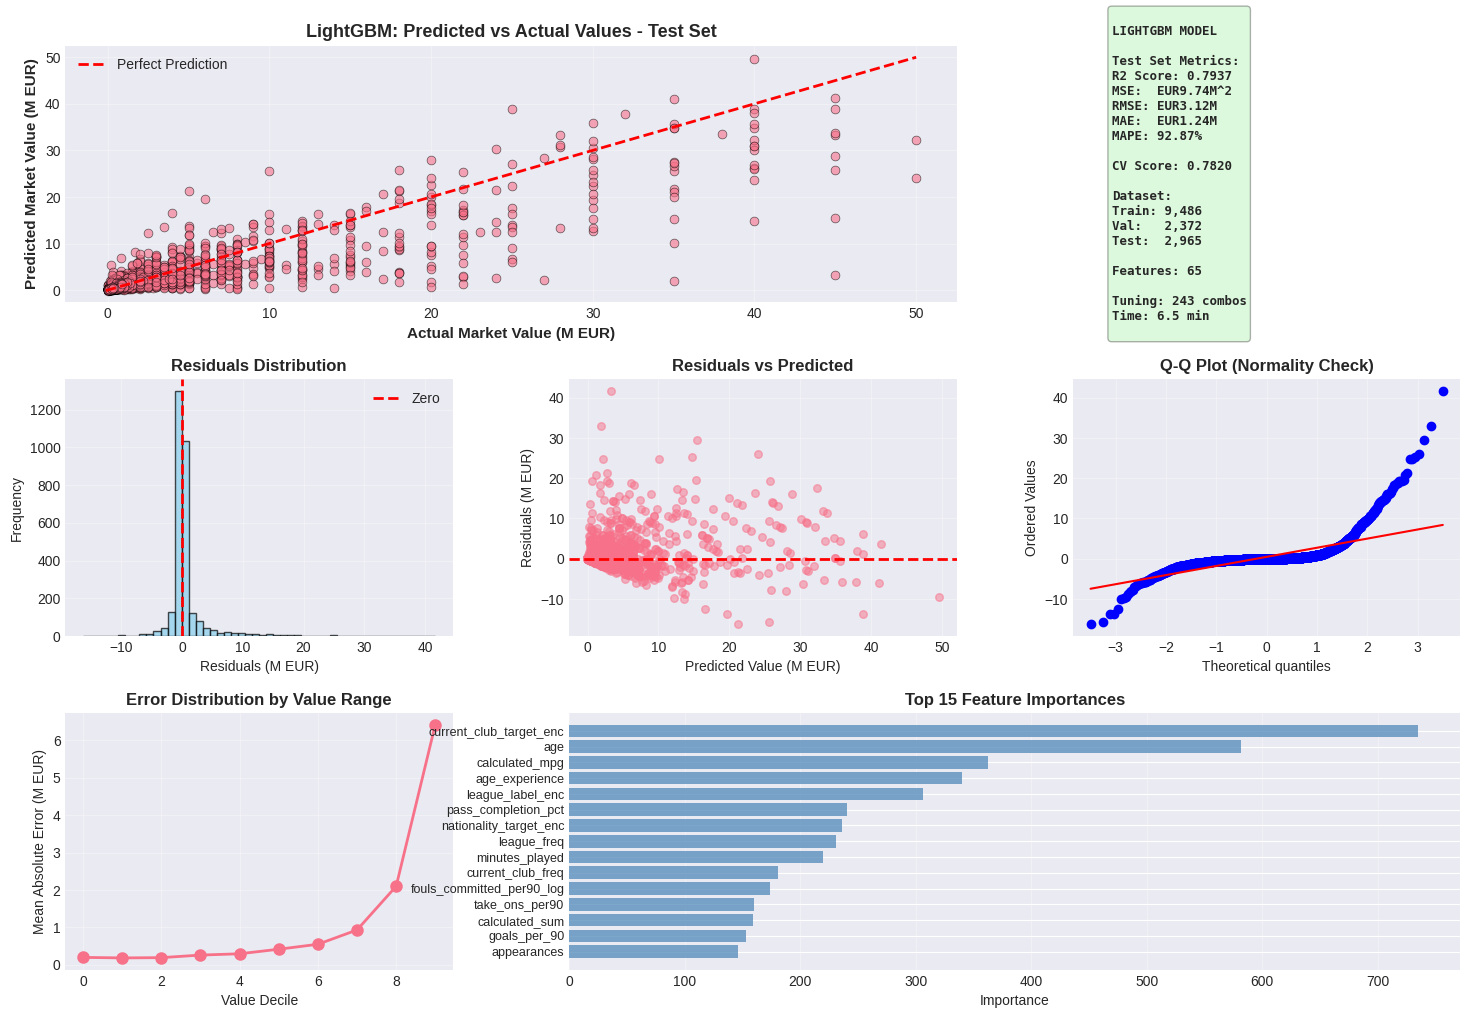

In [13]:
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

y_pred_final = np.expm1(y_test_pred_tuned)
y_test_actual = np.expm1(y_test)
residuals = y_test_actual - y_pred_final

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, :2])
ax1.scatter(y_test_actual, y_pred_final, alpha=0.6, s=40, edgecolors='black', linewidth=0.5)
min_val = min(y_test_actual.min(), y_pred_final.min())
max_val = max(y_test_actual.max(), y_pred_final.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Market Value (M EUR)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Predicted Market Value (M EUR)', fontsize=11, fontweight='bold')
ax1.set_title('LightGBM: Predicted vs Actual Values - Test Set', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

ax2 = fig.add_subplot(gs[0, 2])
ax2.axis('off')
metrics_text = f"""
LIGHTGBM MODEL

Test Set Metrics:
R2 Score: {final_metrics['r2']:.4f}
MSE:  EUR{final_metrics['mse']:.2f}M^2
RMSE: EUR{final_metrics['rmse']:.2f}M
MAE:  EUR{final_metrics['mae']:.2f}M
MAPE: {final_metrics['mape']:.2f}%

CV Score: {grid_search.best_score_:.4f}

Dataset:
Train: {len(X_train):,}
Val:   {len(X_val):,}
Test:  {len(X_test):,}

Features: {len(selected_features)}

Tuning: {n_combinations} combos
Time: {tune_time/60:.1f} min
"""
ax2.text(0.1, 0.5, metrics_text, fontsize=9, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3),
         fontweight='bold', family='monospace')

ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax3.axvline(0, color='red', linestyle='--', lw=2, label='Zero')
ax3.set_xlabel('Residuals (M EUR)', fontsize=10)
ax3.set_ylabel('Frequency', fontsize=10)
ax3.set_title('Residuals Distribution', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(y_pred_final, residuals, alpha=0.5, s=30)
ax4.axhline(0, color='red', linestyle='--', lw=2)
ax4.set_xlabel('Predicted Value (M EUR)', fontsize=10)
ax4.set_ylabel('Residuals (M EUR)', fontsize=10)
ax4.set_title('Residuals vs Predicted', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

ax5 = fig.add_subplot(gs[1, 2])
stats.probplot(residuals, dist="norm", plot=ax5)
ax5.set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
ax5.grid(alpha=0.3)

ax6 = fig.add_subplot(gs[2, 0])
percentiles = np.percentile(y_test_actual, np.arange(0, 101, 10))
mean_errors = []
for i in range(len(percentiles)-1):
    mask = (y_test_actual >= percentiles[i]) & (y_test_actual < percentiles[i+1])
    if mask.sum() > 0:
        mean_errors.append(np.abs(residuals[mask]).mean())
ax6.plot(range(len(mean_errors)), mean_errors, marker='o', linewidth=2, markersize=8)
ax6.set_xlabel('Value Decile', fontsize=10)
ax6.set_ylabel('Mean Absolute Error (M EUR)', fontsize=10)
ax6.set_title('Error Distribution by Value Range', fontsize=12, fontweight='bold')
ax6.grid(alpha=0.3)

if hasattr(final_model, 'feature_importances_'):
    ax7 = fig.add_subplot(gs[2, 1:])
    importances = final_model.feature_importances_
    indices = np.argsort(importances)[-15:]
    
    ax7.barh(range(len(indices)), importances[indices], alpha=0.7, color='steelblue')
    ax7.set_yticks(range(len(indices)))
    ax7.set_yticklabels([selected_features[i] for i in indices], fontsize=9)
    ax7.set_xlabel('Importance', fontsize=10)
    ax7.set_title('Top 15 Feature Importances', fontsize=12, fontweight='bold')
    ax7.grid(alpha=0.3, axis='x')

output_file = os.path.join(FIGURES_FOLDER, 'LGBM_final_evaluation.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\nSaved: {output_file}")
plt.show()

### **X. Save Results**

In [14]:
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

model_file = os.path.join(MODEL_FOLDER, 'LGBM_final_model.pkl')
scaler_file = os.path.join(MODEL_FOLDER, 'LGBM_scaler.pkl')
features_file = os.path.join(MODEL_FOLDER, 'LGBM_selected_features.pkl')
metadata_file = os.path.join(MODEL_FOLDER, 'LGBM_metadata.pkl')

joblib.dump(final_model, model_file)
joblib.dump(scaler, scaler_file)
joblib.dump(selected_features, features_file)

metadata = {
    'model_name': 'LightGBM',
    'n_features': len(selected_features),
    'feature_names': selected_features,
    'n_train': len(X_train),
    'n_val': len(X_val),
    'n_test': len(X_test),
    'split_ratio': '64/16/20',
    'test_r2': final_metrics['r2'],
    'test_mse': final_metrics['mse'],
    'test_rmse': final_metrics['rmse'],
    'test_mae': final_metrics['mae'],
    'test_mape': final_metrics['mape'],
    'best_params': grid_search.best_params_,
    'cv_score': grid_search.best_score_,
    'cv_folds': n_folds,
    'n_param_combinations': n_combinations,
    'training_time_seconds': train_time,
    'tuning_time_seconds': tune_time
}

joblib.dump(metadata, metadata_file)

print(f"Saved: {model_file}")
print(f"Saved: {scaler_file}")
print(f"Saved: {features_file}")
print(f"Saved: {metadata_file}")


SAVING RESULTS
Saved: output/models/LGBM_final_model.pkl
Saved: output/models/LGBM_scaler.pkl
Saved: output/models/LGBM_selected_features.pkl
Saved: output/models/LGBM_metadata.pkl


### **XI. Final Report**

In [15]:
print("\n" + "="*80)
print("FINAL REPORT")
print("="*80)

total_time = time.time() - fe_start

report = f"""
{'='*80}
LIGHTGBM MODEL - FINAL REPORT
{'='*80}

EXECUTION TIME
   Total runtime:         {total_time/60:.2f} minutes ({total_time:.1f}s)
   Feature engineering:   {fe_time:.2f}s
   Initial training:      {train_time:.2f}s
   Hyperparameter tuning: {tune_time/60:.2f} minutes ({tune_time:.1f}s)

DATASET INFORMATION
   Total samples:    {len(df):,}
   After cleaning:   {len(df_clean):,} ({len(df_clean)/len(df)*100:.1f}%)
   Features:         {len(selected_features)}
   
   Split (64%/16%/20%):
   - Training:   {len(X_train):,} samples
   - Validation: {len(X_val):,} samples
   - Test:       {len(X_test):,} samples

HYPERPARAMETER TUNING STRATEGY
   Parameter combinations: {n_combinations}
   Cross-validation: {n_folds}-fold
   Total fits: {total_fits}
   Actual time: {tune_time/60:.2f} minutes

BEST HYPERPARAMETERS
{chr(10).join([f'   - {k}: {v}' for k, v in grid_search.best_params_.items()])}

PERFORMANCE METRICS
   
   Initial Model (before tuning):
   - CV R2:      {initial_results['cv_mean']:.4f} +/- {initial_results['cv_std']:.4f}
   - Test R2:    {initial_results['test_r2']:.4f}
   - Test RMSE:  EUR{initial_results['test_rmse']:.2f}M
   - Test MAE:   EUR{initial_results['test_mae']:.2f}M
   
   Tuned Model (after GridSearchCV):
   - CV R2:      {grid_search.best_score_:.4f}
   - Test R2:    {final_metrics['r2']:.4f}
   - Test MSE:   EUR{final_metrics['mse']:.2f}M^2
   - Test RMSE:  EUR{final_metrics['rmse']:.2f}M
   - Test MAE:   EUR{final_metrics['mae']:.2f}M
   - Test MAPE:  {final_metrics['mape']:.2f}%
   
   Improvement: {improvement:+.2f}%

FEATURE ENGINEERING APPLIED
   - Log transformation for {len(skewed_features)} skewed features
   - Ratio features: goals_per_shot, pass_efficiency, defensive_contribution, total_progressive
   - Interaction features: age_experience, minutes_per_game
   - Polynomial features: goals^2, assists^2, minutes_played^2
   - Target encoding for nationality, current_club
   - Label encoding for position, league
   - Frequency encoding for all categorical variables

OUTPUT FILES
   - LGBM_final_evaluation.png
   - LGBM_final_model.pkl
   - LGBM_scaler.pkl
   - LGBM_selected_features.pkl
   - LGBM_metadata.pkl
   - LGBM_report.txt

Completed at: {time.strftime('%H:%M:%S on %Y-%m-%d')}
{'='*80}

Model trained with {n_combinations} parameter combinations
Total runtime: {total_time/60:.2f} minutes
Final Test R2: {final_metrics['r2']:.4f}
Final Test RMSE: EUR{final_metrics['rmse']:.2f}M
{'='*80}
"""

print(report)

report_file = os.path.join(REPORT_FOLDER, 'LGBM_final_report.txt')
with open(report_file, 'w', encoding='utf-8') as f:
    f.write(report)

print(f"\nSaved: {report_file}")
print("\n" + "="*80)
print("ALL TASKS COMPLETED SUCCESSFULLY")
print("="*80)
print(f"\nSummary:")
print(f"   Model: LightGBM")
print(f"   Test R2: {final_metrics['r2']:.4f}")
print(f"   Test RMSE: EUR{final_metrics['rmse']:.2f}M")
print(f"   Tuning: {n_combinations} combinations in {tune_time/60:.2f} minutes")
print(f"   Total time: {total_time/60:.2f} minutes")
print(f"\nReady for comparison with Random Forest & XGBoost")
print(f"   Same pipeline - Same data split - Same metrics")
print("\n" + "="*80)


FINAL REPORT

LIGHTGBM MODEL - FINAL REPORT

EXECUTION TIME
   Total runtime:         6.56 minutes (393.4s)
   Feature engineering:   0.04s
   Initial training:      0.97s
   Hyperparameter tuning: 6.46 minutes (387.4s)

DATASET INFORMATION
   Total samples:    14,977
   After cleaning:   14,823 (99.0%)
   Features:         65

   Split (64%/16%/20%):
   - Training:   9,486 samples
   - Validation: 2,372 samples
   - Test:       2,965 samples

HYPERPARAMETER TUNING STRATEGY
   Parameter combinations: 243
   Cross-validation: 5-fold
   Total fits: 1215
   Actual time: 6.46 minutes

BEST HYPERPARAMETERS
   - learning_rate: 0.05
   - max_depth: 6
   - min_child_samples: 20
   - n_estimators: 300
   - num_leaves: 31

PERFORMANCE METRICS

   Initial Model (before tuning):
   - CV R2:      0.7816 +/- 0.0113
   - Test R2:    0.7928
   - Test RMSE:  EUR3.12M
   - Test MAE:   EUR1.24M

   Tuned Model (after GridSearchCV):
   - CV R2:      0.7820
   - Test R2:    0.7937
   - Test MSE:   EUR9.74